In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from copy import deepcopy
from itertools import product
from ipywidgets import IntProgress
from IPython.display import display
import warnings

warnings.filterwarnings('ignore')

In [2]:
# download data
train = pd.read_csv('train_kaggle.csv')
test = pd.read_csv('test_kaggle.csv')
train['Date'] = pd.to_datetime(train['Date'], dayfirst = True)
test['Date'] = pd.to_datetime(test['Date'], dayfirst = True)
train.set_index(['Date'], inplace=True)
test.set_index(['Date'], inplace=True)

In [3]:
train['Promo'] = train['Promo'].fillna(0)
train.reset_index().set_index(['SKU_id', 'Store_id', 'Date'], inplace=True)
train['Regular_Price'] = train['Regular_Price'].ffill().bfill()
train.reset_index().set_index(['Date'], inplace=True)

# add actual price (promo price when promo occurred or regular price otherwise)

train['Actual_Price'] = train.Promo_Price.combine_first(train.Regular_Price) 
train.head()

,Store_id,SKU_id,Promo,Demand,Regular_Price,Promo_Price,Actual_Price
Date,,,,,,,
2015-01-01,1,1,0.0,22,163.78,NaN,163.78
2015-01-02,1,1,0.0,41,163.78,NaN,163.78
2015-01-03,1,1,0.0,35,163.78,NaN,163.78
2015-01-04,1,1,0.0,72,163.78,NaN,163.78
2015-01-05,1,1,0.0,25,163.78,NaN,163.78


In [4]:
test['Promo'] = test['Promo'].fillna(0)
test.reset_index().set_index(['SKU_id', 'Store_id', 'Date'], inplace=True)
test['Regular_Price'] = test['Regular_Price'].ffill().bfill()
test.reset_index().set_index(['Date'], inplace=True)

# add actual price (promo price when promo occurred or regular price otherwise)

test['Actual_Price'] = test.Promo_Price.combine_first(test.Regular_Price) 
test.head()

,Store_id,SKU_id,Promo,Demand,Regular_Price,Promo_Price,Actual_Price
Date,,,,,,,
2016-05-23,1,1,1.0,NaN,128.98,119.6,119.60
2016-05-24,1,1,0.0,NaN,128.98,NaN,128.98
2016-05-25,1,1,0.0,NaN,131.70,NaN,131.70
2016-05-26,1,1,0.0,NaN,131.70,NaN,131.70
2016-05-27,1,1,0.0,NaN,131.70,NaN,131.70


In [5]:
train.reset_index(inplace=True)
train["weekday"] = train.Date.dt.weekday
train["monthday"] = train.Date.dt.day
train['is_weekend'] = train.weekday.isin([5, 6]) * 1

test.reset_index(inplace=True)
test["weekday"] = test.Date.dt.weekday
test["monthday"] = test.Date.dt.day
test['is_weekend'] = test.weekday.isin([5, 6]) * 1

In [6]:
data = pd.concat([train, test]).set_index('Date').reset_index()
data.head()

,Date,Store_id,SKU_id,Promo,Demand,Regular_Price,Promo_Price,Actual_Price,weekday,monthday,is_weekend
0,2015-01-01,1,1,0.0,22.0,163.78,NaN,163.78,3,1,0
1,2015-01-02,1,1,0.0,41.0,163.78,NaN,163.78,4,2,0
2,2015-01-03,1,1,0.0,35.0,163.78,NaN,163.78,5,3,1
3,2015-01-04,1,1,0.0,72.0,163.78,NaN,163.78,6,4,1
4,2015-01-05,1,1,0.0,25.0,163.78,NaN,163.78,0,5,0


In [7]:
def percentile(n):
    '''Calculate n - percentile of data'''
    def percentile_(x):
        return np.nanpercentile(x, n)
    percentile_.__name__ = 'perc%s' % n
    return percentile_

## add missing dates to GroupBy.Core object
def fill_missing_dates(x, date_col):
    min_date, max_date = x[date_col].min(), x[date_col].max()
    groupby_day = x.groupby(pd.PeriodIndex(x[date_col], freq='D'))
    results = groupby_day.sum(min_count=1)
    
    idx = pd.period_range(min_date, max_date)
    results = results.reindex(idx, fill_value=np.nan)
    
    results.index.rename(date_col, inplace=True)
    
    return results


def calc_preag_fill(data, group_col, date_col, target_cols, preagg_method):
    ## calc preaggregation 
    data_preag = data.groupby(group_col).agg(preagg_method)[target_cols].reset_index()
    
    ## fill missing dates
    data_preag_filled = data_preag.groupby(group_col[:-1]).apply(fill_missing_dates, date_col=date_col).drop(group_col[:-1], axis=1).reset_index()
    
    ## return DataFrame with calculated preaggregation and filled missing dates
    return data_preag_filled

def calc_rolling(data_preag_filled, group_col, date_col, method, w):
    
    ## calc rolling stats
    lf_df_filled = data_preag_filled.groupby(group_col[:-1]).\
        apply(lambda x: x.set_index(date_col).rolling(w, min_periods=1).agg(method)).drop(group_col[:-1], axis=1)

    ## return DataFrame with rolled columns from target_vars
    return lf_df_filled

def calc_ewm(data_preag_filled, group_col, date_col, alpha):    
    ## calc ewm stats
    lf_df_filled = data_preag_filled.groupby(group_col[:-1]).\
        apply(lambda x: x.set_index(date_col).ewm(alpha=alpha, ignore_na=True).mean()).drop(group_col[:-1], axis=1)
    
    ## return DataFrame with rolled columns from target_vars
    return lf_df_filled


def shift(lf_df_filled, group_col, date_col, lag):
    
    lf_df = lf_df_filled.groupby(level=group_col[:-1]).apply(lambda x: x.shift(lag)).reset_index()
    lf_df[date_col] = pd.to_datetime(lf_df[date_col].astype(str))

    ## return DataFrame with following columns: filter_col, id_cols, date_col and shifted stats
    return lf_df



def lagged_features(data,
                    target_cols = ['Demand'],
                    id_cols = ['SKU_id'],
                    date_col = 'Date',
                    lags = [7, 14, 21, 28],
                    windows = ['7D', '14D', '28D', '56D'],
                    preagg_methods = ['mean'], # ['mean', 'count']
                    agg_methods = ['mean', 'median', percentile(10),  percentile(90)],
                    dynamic_filters = ['weekday'],
                    static_filters = None,
                    alphas = [0.1, 0.9]
                    ):
    
    '''Calculate lagged features '''
    ''' data - dataframe with default index
        target_cols - column names to calculate lags
        id_cols - key columns
        lags - lag values(days)
        windows - list of windows(string type), calculation is performed within time range length of window
        preagg_methods - applied methods before rolling
        agg_methods - method of aggregation, e.g. 'mean', 'median', percentile, etc.
        dynamic_filters - column names of filter
        static_filters - ...
        alphas - alpha values for ewm method
    '''
    
    data = data.sort_values(date_col)
    out_df = deepcopy(data)
    dates = [min(data[date_col]), max(data[date_col])]
    
    total = len(target_cols) * len(lags) * len(windows) * len(preagg_methods) * len(agg_methods) * len(dynamic_filters)
    progress = IntProgress(min=0, max=total)
    display(progress)
    
    
    for filter_col in dynamic_filters:
        group_col = group_col = [filter_col] + id_cols + [date_col]
        for lag in lags:         
            for preagg in preagg_methods:
                data_preag_filled = calc_preag_fill(data, group_col, date_col, target_cols, preagg)
                
                ## add ewm features
                for alpha in alphas:
                    ewm_filled = calc_ewm(data_preag_filled, group_col, date_col, alpha)
                    ewm = shift(ewm_filled, group_col, date_col, lag)
                    new_names = {x: "{0}_lag{1}d_alpha{2}_key{3}_preag{4}_{5}_dynamic_ewm".
                                     format(x, lag, alpha, '_'.join(id_cols), preagg, filter_col) for x in target_cols}

                    out_df = pd.merge(out_df, ewm.rename(columns=new_names), how='left', on=group_col)
            
                for w in windows: 
                    for method in agg_methods:
                        rolling_filled = calc_rolling(data_preag_filled, group_col, date_col, method, w)

                        ## lf_df - DataFrame with following columns: filter_col, id_cols, date_col, shifted rolling stats
                        rolling = shift(rolling_filled, group_col, date_col, lag)

                        method_name = method.__name__ if type(method) != str else method

                        new_names = {x: "{0}_lag{1}d_w{2}_key{3}_preag{4}_ag{5}_{6}_dynamic_rolling".
                                     format(x, lag, w, '_'.join(id_cols), preagg, method_name, filter_col) for x in target_cols}

                        out_df = pd.merge(out_df, rolling.rename(columns=new_names), how='left', on=group_col)
                        progress.value += 1
    
    return out_df



In [8]:
data_lagged_features = lagged_features(data 
                    , target_cols = ['Demand']
                    , id_cols = ['SKU_id', 'Store_id']
                    , date_col = 'Date'
                    , lags = [21]
                    , windows = ['14D', '28D']
                    , preagg_methods = ['mean'] # ['mean', 'count']
                    , agg_methods = ['mean']
                    , dynamic_filters = ['weekday', 'Promo']
                    , static_filters=[]
                    , alphas=[0.25, 0.5, 0.75]
                    )

data_lagged_features


IntProgress(value=0, max=4)

,Date,Store_id,SKU_id,Promo,Demand,Regular_Price,Promo_Price,Actual_Price,weekday,monthday,...,Demand_lag21d_alpha0.25_keySKU_id_Store_id_preagmean_weekday_dynamic_ewm,Demand_lag21d_alpha0.5_keySKU_id_Store_id_preagmean_weekday_dynamic_ewm,Demand_lag21d_alpha0.75_keySKU_id_Store_id_preagmean_weekday_dynamic_ewm,Demand_lag21d_w14D_keySKU_id_Store_id_preagmean_agmean_weekday_dynamic_rolling,Demand_lag21d_w28D_keySKU_id_Store_id_preagmean_agmean_weekday_dynamic_rolling,Demand_lag21d_alpha0.25_keySKU_id_Store_id_preagmean_Promo_dynamic_ewm,Demand_lag21d_alpha0.5_keySKU_id_Store_id_preagmean_Promo_dynamic_ewm,Demand_lag21d_alpha0.75_keySKU_id_Store_id_preagmean_Promo_dynamic_ewm,Demand_lag21d_w14D_keySKU_id_Store_id_preagmean_agmean_Promo_dynamic_rolling,Demand_lag21d_w28D_keySKU_id_Store_id_preagmean_agmean_Promo_dynamic_rolling
0,2015-01-01,1,1,0.0,22.0,163.78,NaN,163.78,3,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-01,19,1,0.0,25.0,163.78,NaN,163.78,3,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-01-01,39,2,0.0,3.0,135.78,NaN,135.78,3,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-01-01,40,2,0.0,0.0,135.78,NaN,135.78,3,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-01-01,18,1,0.0,13.0,163.78,NaN,163.78,3,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92881,2016-06-19,47,1,1.0,NaN,134.96,125.04,125.04,6,19,...,879.707046,1290.465589,1708.099787,2127.0,988.666667,1552.312041,1822.452755,2002.867827,1529.666667,1529.666667
92882,2016-06-19,47,2,0.0,NaN,139.86,NaN,139.86,6,19,...,36.661924,28.710168,12.033514,3.0,66.000000,2.920313,2.999293,3.000000,3.000000,2.571429
92883,2016-06-19,48,2,0.0,NaN,137.14,NaN,137.14,6,19,...,16.473689,14.439218,8.850858,6.0,29.333333,5.732058,5.981206,5.999843,6.000000,5.428571
92884,2016-06-19,45,2,0.0,NaN,139.86,NaN,139.86,6,19,...,27.836227,20.692871,9.277797,3.0,42.666667,6.543075,3.944805,3.563722,5.285714,12.714286


<AxesSubplot:title={'center':'Demand_lag21d_alpha0.5_keySKU_id_Store_id_preagmean_Promo_dynamic_ewm'}, xlabel='Date'>

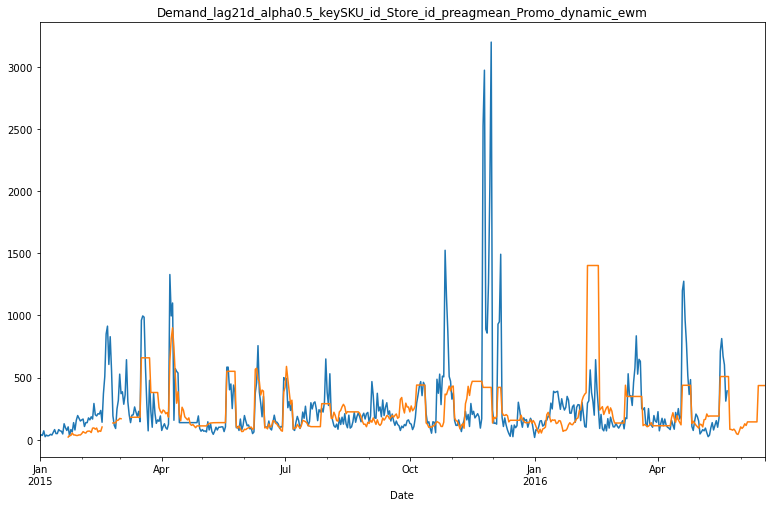

In [14]:
f = 'Demand_lag21d_alpha0.5_keySKU_id_Store_id_preagmean_Promo_dynamic_ewm'
store = 1
sku = 1

plt.figure(figsize=(13, 8))
plt.title(f)
data_lagged_features[(data_lagged_features['SKU_id'] == sku) & (data_lagged_features['Store_id'] == store)].set_index('Date')['Demand'].plot()
data_lagged_features[(data_lagged_features['SKU_id'] == sku) & (data_lagged_features['Store_id'] == store)].set_index('Date')[f].plot()



<AxesSubplot:title={'center':'Demand_lag21d_alpha0.75_keySKU_id_Store_id_preagmean_weekday_dynamic_ewm'}, xlabel='Date'>

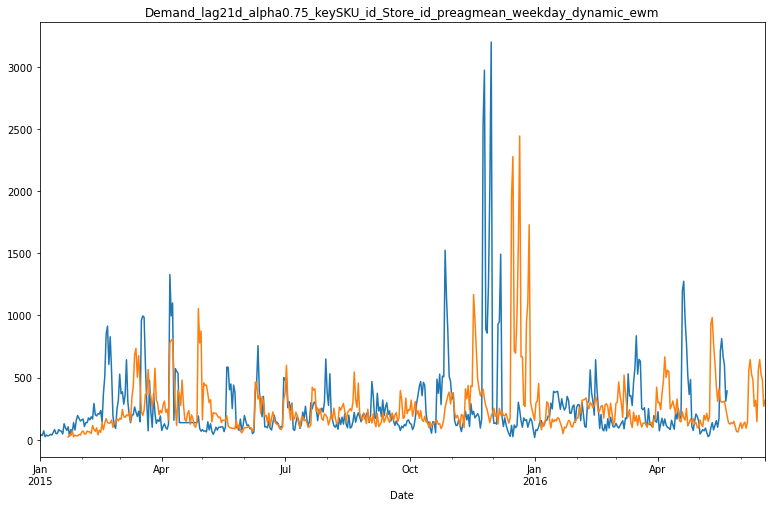

In [18]:
f = 'Demand_lag21d_alpha0.75_keySKU_id_Store_id_preagmean_weekday_dynamic_ewm'
store = 1
sku = 1

plt.figure(figsize=(13, 8))
plt.title(f)
data_lagged_features[(data_lagged_features['SKU_id'] == sku) & (data_lagged_features['Store_id'] == store)].set_index('Date')['Demand'].plot()
data_lagged_features[(data_lagged_features['SKU_id'] == sku) & (data_lagged_features['Store_id'] == store)].set_index('Date')[f].plot()



<AxesSubplot:title={'center':'Demand_lag21d_alpha0.25_keySKU_id_Store_id_preagmean_weekday_dynamic_ewm'}, xlabel='Date'>

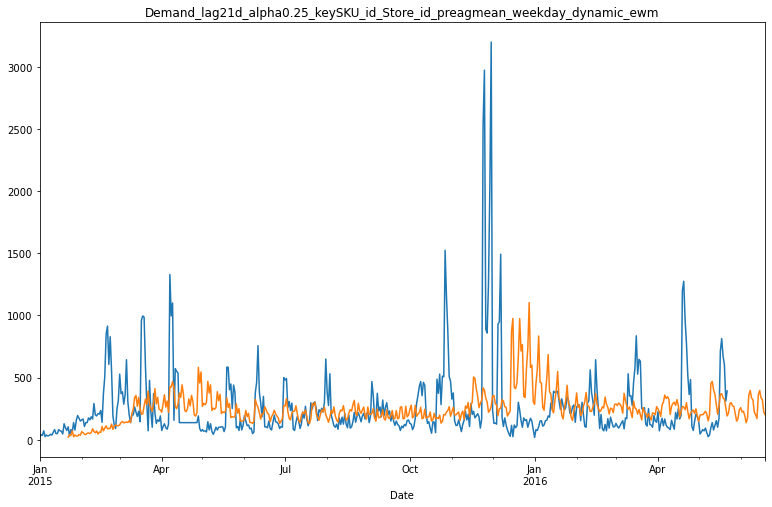

In [19]:
f = 'Demand_lag21d_alpha0.25_keySKU_id_Store_id_preagmean_weekday_dynamic_ewm'
store = 1
sku = 1

plt.figure(figsize=(13, 8))
plt.title(f)
data_lagged_features[(data_lagged_features['SKU_id'] == sku) & (data_lagged_features['Store_id'] == store)].set_index('Date')['Demand'].plot()
data_lagged_features[(data_lagged_features['SKU_id'] == sku) & (data_lagged_features['Store_id'] == store)].set_index('Date')[f].plot()



In [20]:
data_lagged_features.isna().sum()

Date                                                                                  0
Store_id                                                                              0
SKU_id                                                                                0
Promo                                                                                 0
Demand                                                                             5970
Regular_Price                                                                         0
Promo_Price                                                                       76023
Actual_Price                                                                          0
weekday                                                                               0
monthday                                                                              0
is_weekend                                                                            0
Demand_lag21d_alpha0.25_keySKU_i